In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

In [2]:
import numpy as np
import pandas as pd
from quetzal.model import stepmodel
from quetzal.io import excel

# Inner-zonal assignment
## Saves transport demand within zones
## Needs inner-zonal volumes and trip lengths by mode

In [3]:
input_path = '../input/transport_demand/'
output_path = '../output/'
model_path = '../model/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

## Load transport demand data from VP2030

The German federal government's transport study "[Bundesverkehrswegeplan 2030](https://www.bmvi.de/SharedDocs/DE/Artikel/G/BVWP/bundesverkehrswegeplan-2030-inhalte-herunterladen.html)" uses origin destination matrices on NUTS3-level resolution and makes them accessible under copyright restrictions for the base year and the year of prognosis. These matrices cannot be published in their original form.

In [5]:
vp2010 = pd.read_excel(input_path + 'PVMatrix_BVWP15_A2010.xlsx')
vp2030 = pd.read_excel(input_path + 'PVMatrix_BVWP15_P2030.xlsx')

In [6]:
print(vp2010.shape)
vp2010[vp2010.isna().any(axis=1)]

(313590, 38)


,# Quelle,Ziel,Bahn_Fz1,Bahn_Fz2,Bahn_Fz3,Bahn_Fz4,Bahn_Fz5,Bahn_Fz6,MIV_Fz1,MIV_Fz2,...,Rad_Fz3,Rad_Fz4,Rad_Fz5,Rad_Fz6,Fuß_Fz1,Fuß_Fz2,Fuß_Fz3,Fuß_Fz4,Fuß_Fz5,Fuß_Fz6


In [7]:
for df in [vp2010, vp2030]:
    df.rename(columns={'# Quelle': 'origin', 'Ziel': 'destination'}, inplace=True)

### Cast to 2017 data

In [8]:
def get_vp2017(vp2010_i, vp2030_i):
    return vp2010_i + (vp2030_i - vp2010_i) * (7/20)

In [9]:
# Calculate a OD table for the year 2017
vp2017 = get_vp2017(vp2010.set_index(['origin', 'destination']),
                    vp2030.set_index(['origin', 'destination']))

In [10]:
vp2017.dropna(how='all', inplace=True)
print(vp2010.shape)
vp2017[vp2017.isna().any(axis=1)]

(313590, 38)


,,Bahn_Fz1,Bahn_Fz2,Bahn_Fz3,Bahn_Fz4,Bahn_Fz5,Bahn_Fz6,MIV_Fz1,MIV_Fz2,MIV_Fz3,MIV_Fz4,...,Rad_Fz3,Rad_Fz4,Rad_Fz5,Rad_Fz6,Fuß_Fz1,Fuß_Fz2,Fuß_Fz3,Fuß_Fz4,Fuß_Fz5,Fuß_Fz6
origin,destination,,,,,,,,,,,,,,,,,,,,,


In [11]:
vp2017 = vp2017[list(vp2017.columns)].astype(int)
#vp2017.head()

In [12]:
# Keep only inner-cell transport demand
vp2017.reset_index(inplace=True)
vp2017 = vp2017.loc[vp2017['origin']==vp2017['destination']]
vp2017.drop('destination', axis=1, inplace=True)
len(vp2017)

412

### Update zone codes and map to NUTS

In [13]:
# NUTS3-level zones changed after the VP2030
# Thus the VP table needs to be updated manually
update_dict = {3156: 3159, 3152: 3159, # Göttingen
               13001: 13075, 13002: 13071, 13005: 13073, 13006: 13074,
               13051: 13072, 13052: 13071, 13053: 13072, 13054: 13076, 13055: 13071, 13056: 13071,
               13057: 13073, 13058: 13074, 13059: 13075, 13060: 13076, 13061: 13073, 13062: 13075}

In [14]:
# What is the sum of all trips? For Validation
cols = [c for c in vp2017.columns if c not in ['origin']]
orig_sum = vp2017[cols].sum().sum()
orig_sum

85242846874

In [15]:
# Update LAU codes
vp2017['origin'] = vp2017['origin'].replace(update_dict)

In [16]:
# Replace LAU with NUTS
sm = stepmodel.read_json(model_path + 'de_zones')
lau_dict = sm.zones.set_index('lau_id')['NUTS_ID'].to_dict()
vp2017['origin'] = vp2017['origin'].astype(str).map(lau_dict)

In [17]:
# Restrict to cells in the model
vp2017 = vp2017[~vp2017.isna().any(axis=1)]
vp2017.shape

(412, 37)

In [18]:
# What is the sum of all trips after ditching outer-German trips?
vp2017[cols].sum().sum() / orig_sum

1.0

In [19]:
# Aggregate origins
vp2017 = vp2017.groupby('origin').sum().reset_index()
vp2017[cols].sum().sum() / orig_sum

1.0

In [20]:
vp2017.shape

(401, 37)

### Re-arrange the modes and purposes

In [21]:
# Merge bicycle and foot
for p in range(1,7):
    vp2017['walk_Fz' + str(p)] = vp2017['Rad_Fz' + str(p)] + vp2017['Fuß_Fz' + str(p)]
vp2017 = vp2017[[col for col in list(vp2017.columns) if not col[:3] in ['Rad', 'Fuß']]]

In [22]:
# Make columns two levels
vp2017.set_index('origin', inplace=True)
mode_dict = {'OESPV': 'bus', 'Bahn': 'rail', 'MIV': 'car', 'Luft': 'air', 'walk': 'walk'}
vp2017.columns = pd.MultiIndex.from_tuples(
    [(col.split('_')[1], mode_dict[col.split('_')[0]]) for col in vp2017.columns],
    names=['segment', 'mode'])

In [23]:
# Merge purpose 5 and 6 due to calibration data limitations
vp2017['Fz6'] = vp2017['Fz5'] + vp2017['Fz6']
vp2017.drop('Fz5', axis=1, inplace=True)

array([<AxesSubplot:ylabel='Fz1'>, <AxesSubplot:ylabel='Fz2'>,
       <AxesSubplot:ylabel='Fz3'>, <AxesSubplot:ylabel='Fz4'>,
       <AxesSubplot:ylabel='Fz6'>], dtype=object)

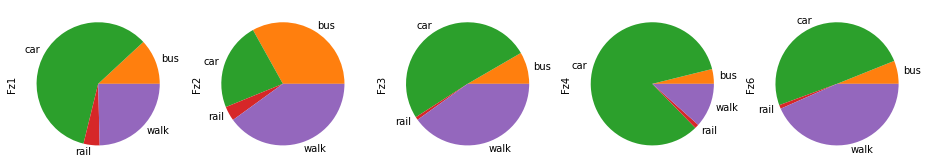

In [24]:
# Modal split by trips
vp2017.T.sum(axis=1).unstack('segment').plot.pie(
    subplots=True, figsize=(16, 4), legend=False)

In [25]:
# Ditch air columns
vp2017.drop('air', axis=1, level=1, inplace=True)

In [26]:
# Clear the RAM
vp2010 = None
vp2030 = None

In [27]:
volumes = vp2017

## Load MiD2017 data for trip lengths

Generate average trip lengths using survey data.

In [28]:
trips = pd.read_csv(input_path + 'MiD2017_Regional_Wege.csv', sep=';')
trips = trips[['KKZ_SO', 'KKZ_ZO', 'SKTYP', 'wegkm_imp', 'km_routing_gr',
               'wegmin_imp1', 'hwzweck1', 'hvm_diff2', 'vm_kombi', 'anzpers',
               'auto', 'P_FKARTE', 'multimodal', 'bahn28', 'bus28', 'bahn28_zo',
               'bus28_zo', 'W_DETAIL', 'W_SO2']]
trips.columns = ['origin', 'destination', 'SKTYP', 'distance', 'distance_routed',
                 'duration', 'purpose', 'mode', 'mode_combo', 'n_persons',
                 'car_avail', 'ticket_type', 'mode_affinity', 'dist_train_origin',
                 'dist_bus_origin', 'dist_train_destination', 'dist_bus_destination',
                 'W_DETAIL', 'W_SO2']

In [29]:
trips['distance'] = pd.to_numeric(trips['distance'].str.replace(',', '.'))

In [30]:
# Filter for inner-German trips
trips = trips.loc[(trips['W_SO2']!=2) & (trips['W_SO2']!=3)]
len(trips)

959778

In [31]:
# Filter unspecified rows
trips = trips.loc[(trips['purpose']!=99) &
                  (trips['origin']<9999) &
                  (trips['destination']<9999) &
                  (trips['mode']<24) &
                  (trips['distance_routed']!=708)]
trips = trips.loc[(trips['origin']>1) &
                  (trips['destination']>1)]
len(trips)

409507

In [32]:
# Filter for inner-zonal traffic
trips = trips.loc[trips['origin']==trips['destination']]
len(trips)

300620

In [33]:
# Remove ferries and air
trips = trips.loc[trips['mode']!=19]
trips = trips.loc[trips['mode']!=23]
len(trips)

300567

In [34]:
trips = trips.loc[trips['origin']!=1] # pandas error
len(trips)

300567

In [35]:
# Align regional specifics with urbanisation degree
mid_urbanisation_dict = {1:1, 2:2, 3:3, 4:3}
trips['urbanisation'] = trips['SKTYP'].map(mid_urbanisation_dict)

In [36]:
trips.groupby('urbanisation')['origin'].sum()

urbanisation
1    552695022
2    835556361
3    674155961
Name: origin, dtype: int64

In [37]:
# Make unknown number of persons equal to one
trips.loc[trips['n_persons']>6] = 1

In [38]:
# Match trip purpose with VP2030 categories
# Note: Holiday trips are included in private (6)
purpose_mid_vp_dict = {1: 'Fz1', 2: 'Fz4', 3: 'Fz2', 4: 'Fz3',
                       5: 'Fz3', 6: 'Fz6', 7: 'Fz6', 99: 'Fz6'}
trips['purpose_vp'] = trips['purpose'].map(purpose_mid_vp_dict)

In [39]:
# Match mode with the model modes
# Non-motorised modes, buses, and rail are merged
mode_mid_vp_dict = {1:'walk', 2:'walk', 3:'walk', 4:'car',
                    5:'car', 6:'car', 7:'car', 8:'car', 9:'car',
                    10:'car', 11:'car', 12:'bus', 13:'bus',
                    14:'bus', 15:'bus', 16:'rail', 17:'car',
                    18:'car', 19:'walk', 20:'rail', 21:'bus',
                    22:'bus', 23:'air', 24:'walk'}
trips['mode_model'] = trips['mode'].map(mode_mid_vp_dict)

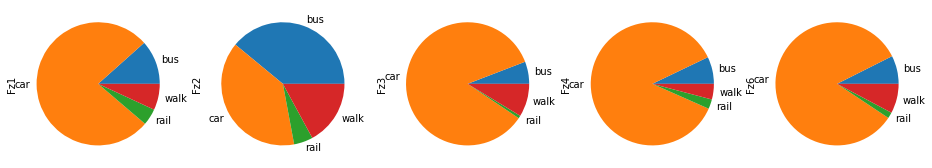

In [40]:
# Modal split by number of trips
axs = trips.groupby(['mode_model','purpose_vp']).size().unstack(fill_value=0).plot.pie(
    subplots=True, figsize=(16, 4), legend=False)

array([<AxesSubplot:ylabel='Fz1'>, <AxesSubplot:ylabel='Fz2'>,
       <AxesSubplot:ylabel='Fz3'>, <AxesSubplot:ylabel='Fz4'>,
       <AxesSubplot:ylabel='Fz6'>], dtype=object)

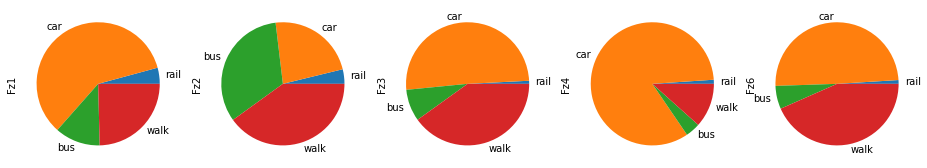

In [41]:
# Compared to VP2030
volumes.T.sum(axis=1).unstack('segment').plot.pie(
    subplots=True, figsize=(16, 4), legend=False)

### Generate averages

In [41]:
# Count the number of observations to grasp statistical validity
trips.groupby(['urbanisation', 'mode_model', 'purpose_vp'])['origin'].count().unstack('purpose_vp')

purpose_vp                 Fz1   Fz2    Fz3   Fz4    Fz6
urbanisation mode_model                                 
1            bus          4001  2051   5434   472   6037
             car          7871  1657  23021  2159  21980
             rail         1336   302    637   148   1144
             walk         2063   853   3844   185   3172
2            bus           851  2643   1265   123   1430
             car         14208  2869  46552  3315  39353
             rail          463   421    190    54    424
             walk          596  1403   4373   110   3215
3            bus           246  2204    424    57    525
             car         11842  2353  33774  2431  28420
             rail          112   160     65    29    122
             walk          369   761   2381    80   1987

In [42]:
trips.groupby(['urbanisation', 'mode_model', 'purpose_vp'])['distance'].mean().unstack('purpose_vp')

purpose_vp                     Fz1        Fz2        Fz3        Fz4        Fz6
urbanisation mode_model                                                       
1            bus          7.516821   5.856412   5.109074   6.758665   5.976490
             car         10.188027   5.778153   5.146724   8.730301   6.820492
             rail        16.859955  14.253411  11.179608  37.126014  19.399755
             walk         1.757179   1.828746   1.378348   2.795892   2.186687
2            bus          9.872703   7.452664   5.877850   7.057480   7.305993
             car         12.081817   5.825612   5.657822  10.598187   7.575102
             rail        25.736847  13.842565  15.896368  28.725741  28.690401
             walk         2.775268   1.577940   1.388191   1.886000   2.383216
3            bus         12.262846   8.523766   6.131698  11.385088   8.838248
             car         11.406599   6.464904   5.870557  11.939646   7.881038
             rail        41.192946  19.702188  29.183231  38.954483  47.320328
             walk         2.377453   1.485742   1.339689   1.738625   2.094620

In [43]:
# Generate average lengths and times
len_dict = trips.groupby(['urbanisation', 'mode_model', 'purpose_vp'])['distance'].mean().to_dict()
time_dict = trips.groupby(['urbanisation', 'mode_model', 'purpose_vp'])['duration'].mean().to_dict()

In [44]:
# Generate average occupation factors for car trips
# Necessary to calculate vehicle kilometers
car_occ_dict = trips.loc[trips['mode_model']=='car'].groupby(
    ['urbanisation', 'purpose_vp'])['n_persons'].mean().to_dict()
trips.loc[trips['mode_model']=='car'].groupby(
    ['urbanisation', 'purpose_vp'])['n_persons'].mean().unstack('purpose_vp')

purpose_vp,Fz1,Fz2,Fz3,Fz4,Fz6
urbanisation,,,,,
1,1.165544,2.415812,1.573998,1.263085,2.117197
2,1.141258,2.362147,1.503093,1.266063,2.048332
3,1.162388,2.436464,1.503997,1.281777,2.060345


### Generate prices

See cal11 for values and explanation

In [45]:
trips['price'] = 0

In [61]:
# Car
vc_car = params['car']['var_cost'] * 1000
fix_car = params['car']['fix_cost']
mask = trips['mode_model']=='car'
trips.loc[mask, 'price'] = [d*vc_car/n + fix_car*t/60 for d,n,t in zip(
    trips.loc[mask,'distance'], trips.loc[mask,'n_persons'], trips.loc[mask,'duration'])]

In [47]:
# PT (same local pricing regime for rail and bus)
# Savings through abonements:
ticket_dict = {1:1, 2:0.9, 3:0.5, 4:0, 5:0, 6:1, 7:1, 99:1, 200:1}
region_prices = {1: params['pt_price']['bus_urban1'],
                 2: params['pt_price']['bus_urban2'],
                 3: params['pt_price']['bus_urban3']}
mask = trips['mode_model'].isin(['bus', 'rail'])
trips.loc[mask, 'price'] = [region_prices[r] * ticket_dict[t] for r,t in zip(
    trips.loc[mask,'urbanisation'], trips.loc[mask,'ticket_type'])]

In [62]:
# Generate averages
price_dict = trips.groupby(['urbanisation', 'mode_model', 'purpose_vp'])['price'].mean().to_dict()
trips.groupby(['urbanisation', 'mode_model', 'purpose_vp'])['price'].mean().unstack('purpose_vp')

purpose_vp                    Fz1       Fz2       Fz3       Fz4       Fz6
urbanisation mode_model                                                  
1            bus         0.805838  1.656959  1.084403  1.124445  1.285036
             car         1.064668  0.358467  0.427288  0.889229  0.453082
             rail        0.618961  1.180377  1.056857  1.036757  1.224378
             walk        0.000000  0.000000  0.000000  0.000000  0.000000
2            bus         1.619741  3.147938  2.041107  1.795122  2.389930
             car         1.286663  0.385747  0.481830  1.073971  0.508775
             rail        1.305400  2.779097  2.410526  2.355556  2.318868
             walk        0.000000  0.000000  0.000000  0.000000  0.000000
3            bus         2.347967  3.506715  2.669811  2.947368  2.659048
             car         1.205227  0.406433  0.501636  1.116185  0.524213
             rail        1.889286  2.770000  2.830769  2.551724  2.852459
             walk        0.000000  0.000000  0.000000  0.000000  0.000000

## Save to excel

Merge volumes and averages into a suitable output format. It should contain columns for
* volumes
* passenger kilometer
* vehicle kilometer
* av. distance
* av. time
* av. price

In [49]:
# Stack column names to columns
df = volumes.stack().stack().rename('volumes').reset_index(level=[1,2])

In [50]:
# Add urbanisation column
df['urb'] = df.index.map(sm.zones['urbanisation'].to_dict()).astype(int)

In [51]:
# Av. distance in km
df['length'] = [len_dict[a] for a in tuple(zip(df['urb'], df['mode'], df['segment']))]

In [52]:
# Av. time in h
df['time'] = [time_dict[a]/60 for a in tuple(zip(df['urb'], df['mode'], df['segment']))]

In [63]:
# Av. price in EUR
df['price'] = [price_dict[a] for a in tuple(zip(df['urb'], df['mode'], df['segment']))]

In [54]:
# Passenger kilometer
df['pkm'] = (df['volumes'] * df['length']).astype(int)

array([<AxesSubplot:ylabel='Fz1'>, <AxesSubplot:ylabel='Fz2'>,
       <AxesSubplot:ylabel='Fz3'>, <AxesSubplot:ylabel='Fz4'>,
       <AxesSubplot:ylabel='Fz6'>], dtype=object)

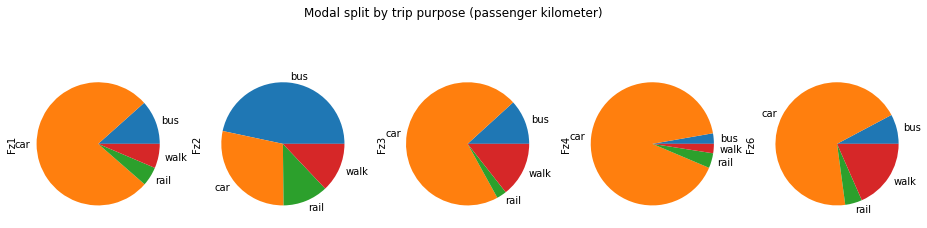

In [55]:
# Modal split by pkm
df.set_index(['mode', 'segment'], append=True)['pkm'].unstack().groupby(level=1).sum(axis=1).plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose (passenger kilometer)')

In [56]:
# Vehicle kilometer for cars
df['vkm'] = [pkm/car_occ_dict[(u,p)] if m=='car' else 0 for u,m,p,pkm in zip(
    df['urb'], df['mode'], df['segment'], df['pkm'])]

In [57]:
# Cycling and walking is not counted to vkm
# PT km depend on the schedules
df['vkm'] = df['vkm'].astype(int)

In [64]:
# Create an aggregated version (NUTS2-level and no segments)
df['NUTS1'] = df.index.str[:3]
df_agg = df.groupby(['NUTS1', 'mode']).agg(
    {'volumes': 'sum', 'length': 'mean', 'time': 'mean',
     'price': 'mean', 'pkm': 'sum', 'vkm': 'sum'})

In [65]:
# Save an excel
with pd.ExcelWriter(output_path + 'inner_zone.xlsx') as writer:
    df.to_excel(writer, sheet_name='inner_zone')
    df_agg.to_excel(writer, sheet_name='agg')

In [67]:
# Save disaggregated pkm as CSV
df[['pkm', 'mode', 'segment']].to_csv(output_path + 'inner_zone_pkm.csv')